In [1]:
#image processing imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image,ImageOps
from kornia import color,losses, filters

#torch imports
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset,DataLoader
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim

#fastai imports
import fastai
from fastai.layers import PixelShuffle_ICNR,ConvLayer,NormType

#additional imports
from collections import OrderedDict
import tqdm
import h5py
import os
import random

# Discriminator

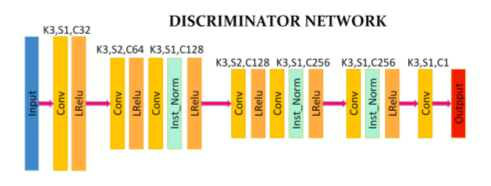

In [2]:
class Discriminator_Block(nn.Module):
    def __init__(self,in_channels,depth):
        super(Discriminator_Block,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels=depth,
                               kernel_size=3,stride=2,
                               padding=1,padding_mode="reflect")
        self.conv2 = nn.Conv2d(in_channels=depth,out_channels=depth*2,
                               kernel_size=3,stride=1,
                               padding=1,padding_mode="reflect",bias=False)
        self.norm = nn.InstanceNorm2d(depth*2)
        self.lrelu = nn.LeakyReLU(0.2)
    def forward(self,x):
        x=self.conv1(x)
        x=self.lrelu(x)
        x=self.conv2(x)
        x=self.norm(x)
        x=self.lrelu(x)
        return x

In [3]:
class Discriminator(nn.Module):
    def __init__(self,in_channels,depth):
        super(Discriminator,self).__init__()
        self.conv1=nn.Conv2d(in_channels=in_channels,out_channels=depth,
                             kernel_size=3,stride=1,padding=1,padding_mode="reflect")
        self.lrelu=nn.LeakyReLU(0.2)
        self.discriminator_block1=Discriminator_Block(in_channels=depth,depth=depth*2)
        self.discriminator_block2=Discriminator_Block(in_channels=depth*4,depth=depth*4)
        self.conv2 = nn.Conv2d(in_channels=depth*8,out_channels=depth*8,
                               kernel_size=3,stride=1,padding=1,padding_mode="reflect",
                               bias=False)
        self.norm = nn.InstanceNorm2d(depth*8)
        self.conv3 = nn.Conv2d(in_channels=depth*8,out_channels=1,
                               kernel_size=3,stride=1,padding=1,padding_mode="reflect")
    def forward(self,x):
        x=self.conv1(x)
        x=self.lrelu(x)
        x=self.discriminator_block1(x)
        x=self.discriminator_block2(x)
        x=self.conv2(x)
        x=self.norm(x)
        x=self.lrelu(x)
        x=self.conv3(x)
        x=torch.sigmoid(x)
        return x
        

# Generator


# Modules

In [4]:
class Encoder_Block(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size,strides,padding):
        super(Encoder_Block,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels=out_channels,
                               kernel_size=kernel_size,stride=strides[0],
                               padding=padding,padding_mode="reflect",
                               bias=False)
        self.conv2 = nn.Conv2d(in_channels=out_channels,out_channels=out_channels,
                               kernel_size=kernel_size,stride=strides[1],
                               padding=padding,padding_mode="reflect",
                               bias=False)
        self.norm = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()
        
    def weight_init(self,mean,std):
        for m in self._modules:
            initialize_weights(self._modules[m],mean,std)
            
    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.norm(x)
        x=self.relu(x)
        return x

In [5]:
class Residual_Block(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Residual_Block,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels=out_channels,
                               kernel_size=3,stride=1,
                               padding=1,padding_mode="reflect",
                               bias=False)
        self.conv2 = nn.Conv2d(in_channels=out_channels,out_channels=out_channels,
                               kernel_size=3,stride=1,
                               padding=1,padding_mode="reflect",
                               bias=False)
        self.norm = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU() 
    def forward(self,x):
        x_=self.conv1(x)
        x_=self.norm(x)
        x_=self.relu(x)
        x_=self.conv2(x)
        x_=self.norm(x)
        x_=torch.add(x_,x)
        x_=self.relu(x)
        return x_

In [6]:
class Decoder_Block(nn.Module):
    def __init__(self,in_channels,out_channels,add_blur=False):
        super(Decoder_Block,self).__init__()
        self.conv_t=nn.ConvTranspose2d(in_channels=in_channels,out_channels=out_channels,
                                       kernel_size=3, stride=2, padding=0)
        self.add_blur = add_blur
        if add_blur:
            self.blur = nn.AvgPool2d(2, 1)
        self.conv = nn.Conv2d(in_channels=out_channels,out_channels=out_channels,
                               kernel_size=3,stride=1,
                               padding=1,padding_mode="reflect",
                               bias=False)
        self.norm = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()
    def forward(self,x):
        x=self.conv_t(x)
        if self.add_blur:
            x=self.blur(x)
        x=self.conv(x)
        x=self.norm(x)
        x=self.relu(x)
        return x

In [7]:
class Encoder(nn.Module):
    def __init__(self,in_channels,depth):
        super(Encoder,self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels,out_channels=depth,
                                      kernel_size=7,stride=1,
                                      padding=3,padding_mode="reflect",
                                      bias=False)
        self.norm = nn.BatchNorm2d(depth)
        self.relu = nn.ReLU()
        self.encoder_block1 = Encoder_Block(in_channels=depth,out_channels=depth*2,
                                            kernel_size=3,strides=[2,1],padding=1)
        self.encoder_block2 = Encoder_Block(in_channels=depth*2,out_channels=depth*4,
                                            kernel_size=3,strides=[2,1],padding=1)
    def forward(self,x):
        x=self.conv(x)
        x=self.norm(x)
        x=self.relu(x)
        x=self.encoder_block1(x)
        x=self.encoder_block2(x)
        return x  

In [8]:
class Transformer(nn.Module):
    def __init__(self,in_channels,depth):
        super(Transformer,self).__init__()
        self.res_block1 = Residual_Block(in_channels=in_channels,out_channels=depth)
        self.res_block2 = Residual_Block(in_channels=depth,out_channels=depth)
        self.res_block3 = Residual_Block(in_channels=depth,out_channels=depth)
        self.res_block4 = Residual_Block(in_channels=depth,out_channels=depth)
        self.res_block5 = Residual_Block(in_channels=depth,out_channels=depth)
        self.res_block6 = Residual_Block(in_channels=depth,out_channels=depth)
        self.res_block7 = Residual_Block(in_channels=depth,out_channels=depth)
        self.res_block8 = Residual_Block(in_channels=depth,out_channels=depth)
    def forward(self,x):
        x=self.res_block1(x)
        x=self.res_block2(x)
        x=self.res_block3(x)
        x=self.res_block4(x)
        x=self.res_block5(x)
        x=self.res_block6(x)
        x=self.res_block7(x)
        x=self.res_block8(x)
        return x

In [9]:
class Decoder(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Decoder,self).__init__()
        self.decoder_block1 = Decoder_Block(in_channels=in_channels,out_channels=in_channels//2,add_blur=True)
        self.decoder_block2 = Decoder_Block(in_channels=in_channels//2,out_channels=in_channels//4,add_blur=True)
        self.conv = nn.Conv2d(in_channels=in_channels//4,out_channels=out_channels,
                              kernel_size=7,stride=1,
                              padding=3,padding_mode="reflect")
    def forward(self,x):
        x=self.decoder_block1(x)
        x=self.decoder_block2(x)
        x=self.conv(x)
        return x

In [10]:
class Generator(nn.Module):
    def __init__(self,in_channels,out_channels,depth):
        super(Generator,self).__init__()
        self.encoder=Encoder(in_channels=in_channels,depth=depth)
        self.transformer=Transformer(in_channels=depth*4,depth=depth*4)
        self.decoder=Decoder(in_channels=depth*4,out_channels=out_channels)
        
    def forward(self,x):
        x=self.encoder(x)
        x=self.transformer(x)
        x=self.decoder(x)
        x=torch.tanh(x)
        return x

# VGG MODELS

In [ ]:
vgg19_model=models.vgg19(pretrained=True)
vgg19_model=vgg19_model.features
for params in vgg19_model.parameters():
    params.requires_grad=False

In [ ]:
vgg16_model=models.vgg16(pretrained=True)
vgg16_model = vgg16_model.features
for params in vgg16_model.parameters():
    params.requires_grad=False

# COLOR LOSS

In [ ]:
class ColorLoss():
    def __init__(self,device):
        self.L1_loss = nn.L1Loss().to(device)
        self.Huber_loss = nn.SmoothL1Loss().to(device)
        
    def YUV_loss(self,y_true,y_pred):
        y_true = color.rgb_to_yuv(y_true)
        y_pred = color.rgb_to_yuv(y_pred)
        Y_loss = self.L1_loss(y_true[:,0,:,:],y_pred[:,0,:,:])
        U_loss = self.Huber_loss(y_true[:,1,:,:],y_pred[:,1,:,:])
        V_loss = self.Huber_loss(y_true[:,2,:,:],y_pred[:,2,:,:])
        YUV_loss = Y_loss + U_loss + V_loss
        return YUV_loss
    
    def HSV_loss(self,y_true,y_pred):
        y_true = color.rgb_to_hsv(y_true)
        y_pred = color.rgb_to_hsv(y_pred)
        H_loss = self.L1_loss(y_true[:,0,:,:],y_pred[:,0,:,:])
        S_loss = self.Huber_loss(y_true[:,1,:,:],y_pred[:,1,:,:])
        V_loss = self.Huber_loss(y_true[:,2,:,:],y_pred[:,2,:,:])
        HSV_loss = H_loss + S_loss + V_loss
        return HSV_loss*0.1
    
    def find(self,y_true,y_pred):
        y_true=(y_true+1)/2
        y_pred=(y_pred+1)/2
        color_loss = self.YUV_loss(y_true,y_pred) + self.HSV_loss(y_true,y_pred)
        return color_loss

# CONTENT LOSS

In [ ]:
class ContentLossModel(nn.Module):
    def __init__(self,device):
        super(ContentLossModel,self).__init__()
        self.vgg19_model = vgg19_model.to(device)
        self.required_layers = {"25":"conv4_4","26":"relu4_4"}

    def forward(self,x):
        outputs={}
        for name,module in self.vgg19_model._modules.items():
            x=module(x)
            for name in self.required_layers:
                outputs.update({self.required_layers[name]:x})
        return outputs
    

In [ ]:
class ContentLoss():
    def __init__(self,device):
        self.device = device
        self.loss_model = ContentLossModel(self.device)
        self.L1_loss = nn.L1Loss().to(self.device)
        
    def fr_loss(self,out_content,out_target):
        total_feature_reconstruction_loss = self.L1_loss(out_target["conv4_4"],out_content["conv4_4"])
        return total_feature_reconstruction_loss
        
    def find(self,x_content,x_target):
        out_content = self.loss_model(x_content)
        out_target = self.loss_model(x_target)
        
        #Feature Reconstruction Loss
        feature_reconstruction_loss = self.fr_loss(out_content,out_target)
        
        return feature_reconstruction_loss
        

# PERCEPTUAL LOSS

In [ ]:
class PerceptualLossModel(nn.Module):
    def __init__(self,device):
        super(PerceptualLossModel,self).__init__()
        self.vgg16_model=vgg16_model.to(device)
        self.required_layers = {'3': "relu1_2",'8': "relu2_2",'15': "relu3_3",'22': "relu4_3"}
        
    def forward(self,x):
        outputs={}
        for name,module in self.vgg16_model._modules.items():
            x=module(x)
            for name in self.required_layers:
                outputs.update({self.required_layers[name]:x})
        return outputs

In [ ]:
class PerceptualLoss():
    def __init__(self,device):
        self.device = device
        self.loss_model=PerceptualLossModel(self.device)
        for param in self.loss_model.parameters():
            param.requires_grad = False
        self.L1_loss = nn.L1Loss().to(self.device)
        self.MSE_loss = nn.MSELoss().to(self.device)
        
    def Gram_matrix(self,x):
        b,c,h,w = x.size()
        x = x.view(b,c,h*w)
        x_t = x.transpose(1,2)
        gram_matrix = x.bmm(x_t)
        return gram_matrix/(c*h*w)
        
    def fr_loss(self,out_content,out_target):
        total_feature_reconstruction_loss = self.L1_loss(out_target["relu3_3"],out_content["relu3_3"])
        return total_feature_reconstruction_loss
    
    def sr_loss(self,out_style,out_target):
        total_style_reconstruction_loss = 0
        for layer in out_style:
            gram_style = self.Gram_matrix(out_style[layer])
            gram_target = self.Gram_matrix(out_target[layer])
            total_style_reconstruction_loss += self.MSE_loss(gram_style,gram_target)
        return total_style_reconstruction_loss
            
        
    def find(self,x_content,x_style,y_target):
        #out_content = self.loss_model.forward(x_content)
        out_style = self.loss_model.forward(x_style)
        out_target = self.loss_model.forward(y_target)
        
        #Feature Reconstruction Loss
        #feature_reconstruction_loss = self.fr_loss(out_content,out_target)
        
        #Style Reconstruction Loss
        style_reconstruction_loss = self.sr_loss(out_style,out_target)
        
        perceptual_loss = style_reconstruction_loss #+ feature_reconstruction_loss
        
        return perceptual_loss
        


# DATASET

In [ ]:
class ImageDataset(Dataset):
    def __init__(self,root_dir,image_size,max_len,grey=None):
        self.root_dir=root_dir
        self.image_size=image_size
        self.file_list=os.listdir(self.root_dir)
        random.shuffle(self.file_list)
        self.file_list=self.file_list[0:2000]
        self.dataset_len=len(self.file_list)
        self.max_len=max_len
        self.grey=grey
        
    def __len__(self):
        return self.max_len
    
    def __getitem__(self,idx):
        file_name=self.file_list[idx%self.dataset_len]
        image_path = os.path.join(self.root_dir,file_name)
        image = np.array(Image.open(image_path))
        image= cv2.resize(image,(self.image_size,self.image_size))
        
        if self.grey=="only" or self.grey=="compliment":
            grey_image=cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            grey_image=np.expand_dims(grey_image,axis=2)
            grey_image=np.concatenate([grey_image,grey_image,grey_image],axis=2)
            grey_image= (grey_image - 127.5) / 127.5
            grey_image= np.transpose(grey_image,(2,0,1))
            grey_image= grey_image.astype(np.float32)
                
        if self.grey=="compliment":
            image= (image - 127.5) / 127.5  
            image= np.transpose(image,(2,0,1))
            image= image.astype(np.float32)
            return image,grey_image
        elif self.grey=="only":
            return grey_image
        elif self.grey is None:
            image= (image - 127.5) / 127.5  
            image= np.transpose(image,(2,0,1))
            image= image.astype(np.float32)
            return image

In [ ]:
cartoon_root="../input/miazaki/dataset/cartoon"
edge_root="../input/miazaki/dataset/edge"
train_root="../input/real-data/dataset_real"
val_root="../input/animegan/val"
cartoon_data=len(os.listdir(cartoon_root))
edge_data = len(os.listdir(edge_root))
real_train_data= len(os.listdir(train_root))
real_val_data=len(os.listdir(val_root))
max_len=2000
#max(cartoon_data,edge_data,real_train_data,real_val_data)
image_size=256
batch_size=8
cartoon_dataset = ImageDataset(root_dir=cartoon_root,image_size=image_size,max_len=max_len,grey="compliment")
edge_dataset = ImageDataset(root_dir=edge_root,image_size=image_size,max_len=max_len,grey="compliment")
train_dataset = ImageDataset(root_dir=train_root,image_size=image_size,max_len=max_len)
val_dataset = ImageDataset(root_dir=val_root,image_size=image_size,max_len=max_len)
cartoon_dataloader = DataLoader(cartoon_dataset,batch_size=batch_size,shuffle=True,num_workers=0)
edge_dataloader = DataLoader(edge_dataset,batch_size=batch_size,shuffle=True,num_workers=0)
real_train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=0)
real_valid_dataloader = DataLoader(val_dataset,batch_size=2,shuffle=True,num_workers=0)
print(len(cartoon_dataloader),len(edge_dataloader),len(real_train_dataloader),len(real_train_dataloader))

# TRAINING

In [ ]:
class Trainer():
    def __init__(self,device,out_dir):
        self.device=device
        self.out_dir=out_dir
        self.MSE_loss=nn.MSELoss()
        self.BCE_loss=nn.BCELoss()
        self.L1_Loss=nn.L1Loss()
        self.Color_loss=ColorLoss(self.device)
        self.Percept_loss=PerceptualLoss(self.device)
        self.Content_loss=ContentLoss(self.device)
        
        self.G_optimizer=optim.AdamW(G.parameters(),lr=0.0002,betas=(0.5, 0.999),weight_decay=1e-3)
        self.D_optimizer=optim.AdamW(D.parameters(),lr=0.0002,betas=(0.5, 0.999),weight_decay=1e-3)
        
        self.omega_adv=300
        self.omega_col=10
        self.omega_gra=3
        self.omega_con=1.5
        
    def initialization(self,G,D):
        for i,(x,e,y) in enumerate(zip(real_train_dataloader,edge_dataloader,cartoon_dataloader)):
            x=x.to(self.device)
            rgb_y=y[0].to(self.device)
            
            #train generator
            self.G_optimizer.zero_grad()
            y_fake=G(x)
            
            G_content_loss =  self.Content_loss.find(x,y_fake)
            G_color_loss = self.Color_loss.find(x,y_fake)
            
            G_loss = self.omega_con*G_content_loss*4 + G_color_loss*self.omega_col
            G_loss.backward()
            self.G_optimizer.step()
            
        return
        
    def train_fn(self,G,D):
        print(real_train_dataloader)
        #x->real world data
        #e->cartoon edge promoted data
        #y->(cartoon rgb data, cartoon grey data)
        for i,(x,e,y) in tqdm.tqdm(enumerate(zip(real_train_dataloader,edge_dataloader,cartoon_dataloader))):
            x=x.to(self.device)
            rgb_e=e[0].to(self.device)
            grey_e=e[1].to(self.device)
            rgb_y=y[0].to(self.device)
            grey_y=y[1].to(self.device)
            
            #train discriminator
            self.D_optimizer.zero_grad()
            y_fake=G(x)
            D_y_fake=D(y_fake.detach())
            D_rgb_y_real=D(rgb_y)
            #D_grey_y_real=D(grey_y)
            D_rgb_edge=D(rgb_e)
            D_grey_edge=D(grey_e)
            
            D_y_real_loss = self.BCE_loss(D_rgb_y_real,torch.ones_like(D_rgb_y_real))
            D_y_fake_loss = self.BCE_loss(D_y_fake,torch.zeros_like(D_y_fake))
            D_edge_loss = self.BCE_loss(D_rgb_edge,torch.zeros_like(D_rgb_edge)) + self.BCE_loss(D_grey_edge,torch.zeros_like(D_grey_edge))
            
            D_loss = D_y_real_loss + D_y_fake_loss + D_edge_loss
            
            D_loss.backward()
            self.D_optimizer.step()
            
            #train generator
            self.G_optimizer.zero_grad()
            y_fake=G(x)
            D_y_fake=D(y_fake)
            G_y_fake_loss = self.BCE_loss(D_y_fake,torch.ones_like(D_y_fake))
            
            G_content_loss =  self.Content_loss.find(x,y_fake)
            """y_fake_gray=color.rgb_to_grayscale(y_fake)
            y_fake_gray=torch.cat([y_fake_gray,y_fake_gray,y_fake_gray],axis=1)"""
            G_perceptual_loss = self.Percept_loss.find(x,grey_y,y_fake)
            
            G_color_loss = self.Color_loss.find(x,y_fake)
            
            G_loss = G_y_fake_loss + 10*G_content_loss + G_perceptual_loss + 4*G_color_loss
            G_loss.backward()
            self.G_optimizer.step()
            
        return
    def save_examples(self,G,epoch,root_dir):
        print("saving")
        if not os.path.exists(root_dir):
            os.mkdir(root_dir)
    
        for j, input_images in enumerate(real_valid_dataloader):
            x = input_images.to("cuda:0")
            fake_images = G(x)
            G.zero_grad()
            for i in range(len(fake_images)):
                input_image = (np.transpose(input_images[i],(1,2,0))+1)/2
                fake_image = np.transpose(np.array(fake_images.detach().cpu())[i],(1,2,0))
                fake_image = (fake_image+1)/2
                output_image = np.concatenate([input_image,fake_image],axis=1)
                file_name = "image_epoch-"+str(epoch)+"_sample-"+str(i)+".png"
                file_path = os.path.join(root_dir,file_name)
                plt.imshow(fake_image)
                plt.imsave(file_path,output_image)
                plt.show()
            break
        return
        
    def fit(self,num_epochs,G,D,initialization=False):
        if not os.path.exists(self.out_dir):
            os.mkdir(self.out_dir)
        if initialization:
            print("Initialization")
            for epoch in tqdm.tqdm(range(30)):
                self.initialization(G,D)
                self.save_examples(G,epoch,self.out_dir)
        print("Training")
        for epoch in range(num_epochs):
            self.train_fn(G,D)
            if epoch%5==0:
                torch.save(G,"Generator_anime_model_cartoon_gan.pth")
                torch.save(D,"Discriminator_anime_model_cartoon_gan.pth")
            self.save_examples(G,epoch,self.out_dir)
        return
        

In [ ]:
D=Discriminator(3,32)
D=torch.load("../input/animeganweight21/Discriminator_anime_model_cartoon_gan (32).pth")
D.to("cuda:0")

In [11]:
G=Generator(3,3,64)
G=torch.load("Generator_anime_model_cartoon_gan (29).pth",map_location=torch.device('cpu'))
"""G.to("cuda:0")"""


'G.to("cuda:0")'

In [ ]:
train=Trainer(device="cuda:0",out_dir="outputs")

In [ ]:
train.fit(num_epochs=10,D=D,G=G,initialization=False)

In [ ]:
torch.save(G,"Generator_anime_model_cartoon_gan.pth")
torch.save(D,"Discriminator_anime_model_cartoon_gan.pth")

In [ ]:
train.save_examples(G,1000,"outputs")

In [ ]:
a.shape

In [ ]:
b.shape

In [ ]:
torch.cuda.empty_cache()